# GNN Training

In [21]:
import os
import gc

from gnn_model.HeteroGAT import HeteroGAT
from gnn_model.Trainer import Trainer
from data_processing.data_loader import DataLoader
from data_processing.config import DataProcessingConfig
from utils import visualize_graph

In [22]:
import torch.serialization
from torch_geometric.data.storage import BaseStorage

# Add BaseStorage class to safe globals for loading
torch.serialization.add_safe_globals([BaseStorage])

## Data Preparation

In [23]:
# Scenarios
# case_study = 'manhattan_case_study'
case_study = 'example_study'
results_dir = os.path.join('..', 'studies', case_study, 'results')
scenario_names = [
    'example_pool_sc_1'
    # 'test_manhattan_scenario_1',
    # 'test_manhattan_scenario_1',
    # 'test_manhattan_scenario_1',
    # 'test_manhattan_scenario_2',
    # 'test_manhattan_scenario_3',
    # 'test_manhattan_scenario_4',
    # 'test_manhattan_scenario_5',
    # 'test_manhattan_scenario_6', 
    # 'test_manhattan_scenario_7', 
    # 'test_manhattan_scenario_8',
    # 'test_manhattan_scenario_9', 
    # 'test_manhattan_scenario_10',
    # 'test_manhattan_scenario_11', 
    # 'test_manhattan_scenario_12',
]
                  
scenarios = [os.path.join(results_dir, sc) for sc in scenario_names]

# Create config
config = DataProcessingConfig(
    # sim_duration=7200,
)

# Set to True only when data needs to be reprocessed
overwrite = False

In [24]:
# random seed for reproducibility
torch.manual_seed(config.random_seed)

In [25]:
# Safe data loading with error handling
def load_data_safely():
    try:
        gc.collect()  # Clean up memory before loading
        torch.cuda.empty_cache()  # Clear GPU cache if available
        
        loader = DataLoader(scenarios, config, overwrite=overwrite)
        data, *masks = loader.load_data()
        
        # Validate loaded data
        if not data or len(data) == 0:
            raise ValueError("No data was loaded")
            
        return data, masks
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None, None

data, masks = load_data_safely()
train_masks, val_masks, test_masks = masks if masks else (None, None, None)

Loading scenarios: 100%|██████████| 1/1 [00:00<00:00, 41.45it/s]

Scenario split: Train=0, Val=0, Test=1 scenarios
Timestep split: Train=0, Val=0, Test=0 timesteps
Error loading data: No data was loaded


In [26]:
# Validate loaded data
if data is not None:
    print(f"Successfully loaded {len(data)} data points")
    print(f"Train/Val/Test split: {sum(train_masks)}/{sum(val_masks)}/{sum(test_masks)}")
else:
    print("Failed to load data. Please check the error message above.")

Failed to load data. Please check the error message above.


## Model Setup

In [27]:
# Model parameters
num_classes = 1  # Binary classification - single output logit with sigmoid activation
hidden_channels = 64  # Size of hidden layers in GNN
epochs = 20  # Maximum number of training epochs (may stop earlier due to early stopping)
batch_size = 128  # Number of graphs per batch

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model with error handling
model = HeteroGAT(hidden_channels, num_classes).to(device=device)
print(f"Model initialized with {hidden_channels} hidden channels and {num_classes} output channel")

Using device: cpu
Model initialized with 64 hidden channels and 1 output channel


In [28]:
# Training setup with weighted BCE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
trainer = Trainer(data, device, masks, config, batch_size=batch_size, epochs=epochs)

TypeError: 'NoneType' object is not subscriptable

In [11]:
# Training with progress tracking and error handling
try:
    # Add numpy scalar to safe globals before training
    import torch.serialization
    torch.serialization.add_safe_globals(['numpy._core.multiarray.scalar'])
    
    # Start training
    trainer.train(model, optimizer)
except Exception as e:
    print(f"Error during training: {str(e)}")
    # Print more detailed error information
    import traceback
    traceback.print_exc()

Logits: tensor([ 0.5102, -0.2324,  0.5473,  0.5913,  2.2639, -0.1961,  0.8189, -1.0608,
        -0.8670, -0.4364], grad_fn=<SliceBackward0>) Target: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
[Batch   0] Loss: 1.5193 | Class dist - Target: [33968, 1352] Pred: [20701, 14619]
Epoch 1/20
--------------------------------------------------------------------------------
Metric          Training        Validation     
--------------------------------------------------------------------------------
Loss            1.5193          -              
Accuracy        0.5862          0.6085         
F1              0.0848          0.1188         
Precision       0.0463          0.0650         
Recall          0.5007          0.6893         
AUC-ROC         0.5669          0.6698         
--------------------------------------------------------------------------------
Logits: tensor([ 1.1669,  0.8117,  3.1497, -0.8684,  0.4294,  0.8164,  1.9533, -0.0166,
         0.1909,  0.3874], grad_fn=<Slice

## Visualization

Let's visualize a sample graph from our dataset and analyze model predictions.

### Graph Visualization Functions

The following cells implement visualization functionality for our heterogeneous graph neural network:

1. Node visualization:
   - Vehicles: red nodes
   - Requests: turquoise nodes

2. Edge visualization:
   - True assignments: solid red lines
   - Non-assignments: dotted gray lines
   - Predicted assignments: semi-transparent blue lines (with probability scores)

3. Additional features:
   - Node labels (V for vehicles, R for requests)
   - Edge probability labels for predicted assignments
   - Comprehensive legend
   - Force-directed layout for clear visualization

/Users/hoda_hamdy/Documents/Projects/fleetpy/FleetPy/notebooks/utils.py:136: RuntimeWarning: invalid value encountered in scalar divide
  perpx, perpy = -dy/length, dx/length
/Users/hoda_hamdy/Documents/Projects/fleetpy/FleetPy/notebooks/utils.py:158: RuntimeWarning: invalid value encountered in scalar divide
  perpx, perpy = -dy/length, dx/length


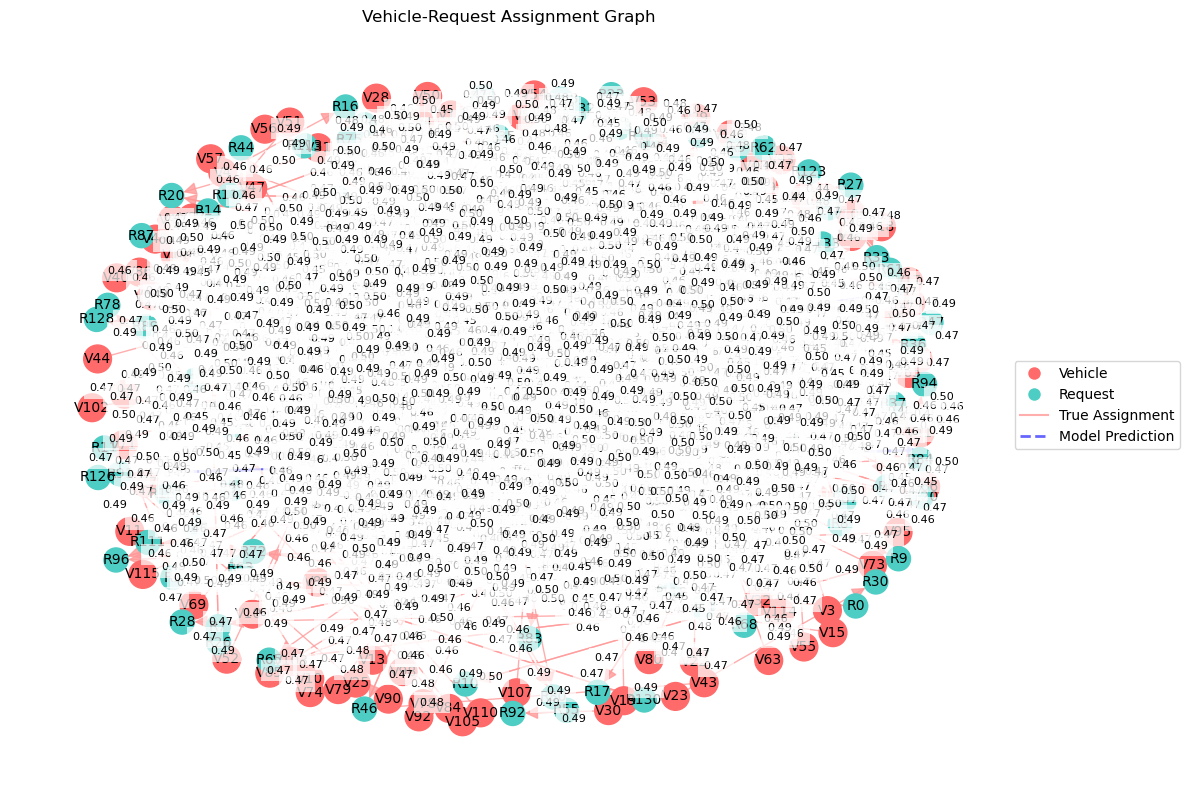

In [12]:
visualize_graph(data, graph_idx=1, model=model, device=device)